# 01. 음악 파형 및 기본 분석 탐색

In [ ]:
import sys
import os

# 프로젝트 루트: cwd 상위로 올라가며 audio_engine + web 있는 디렉터리 (노트북 위치 무관)
def find_project_root():
    cwd = os.path.abspath(os.getcwd())
    while cwd:
        if os.path.isdir(os.path.join(cwd, 'audio_engine')) and os.path.isdir(os.path.join(cwd, 'web')):
            return cwd
        cwd = os.path.dirname(cwd)
    return os.path.abspath(os.path.join(os.path.dirname(os.getcwd()), '..', '..'))  # fallback
project_root = find_project_root()
sys.path.insert(0, project_root)

import librosa
import matplotlib.pyplot as plt
import numpy as np

# 한글 폰트 설정 (macOS 기본 폰트 사용)
plt.rcParams['font.family'] = ['AppleGothic', 'Apple SD Gothic Neo', 'sans-serif']
plt.rcParams['axes.unicode_minus'] = False  # 마이너스 기호 깨짐 방지

print(f"프로젝트 루트: {project_root}")
print(f"Librosa 버전: {librosa.__version__}")

프로젝트 루트: /Users/laxogud/MADCAMP/W4/music-anaylzer
Librosa 버전: 0.11.0


In [27]:
# 샘플 파일 경로 (절대 경로로 변경)
# audio_path = os.path.join(project_root, 'audio_engine', 'samples', 'sample_cardmani.mp3')
audio_path = os.path.join(project_root, 'audio_engine', 'samples', 'sample_ropes_short.mp3')


# 파일 존재 확인
if os.path.exists(audio_path):
    print(f"파일 경로: {audio_path}")
    # 오디오 로드 
    y, sr = librosa.load(audio_path)
    print(f"샘플링 레이트: {sr} Hz")
    print(f"길이: {len(y) / sr:.2f} 초")
    print(f"샘플 수: {len(y)}")
else:
    print(f"파일을 찾을 수 없습니다: {audio_path}")

파일 경로: /Users/laxogud/MADCAMP/W4/music-anaylzer/audio_engine/samples/sample_ropes_short.mp3
샘플링 레이트: 22050 Hz
길이: 31.11 초
샘플 수: 686016


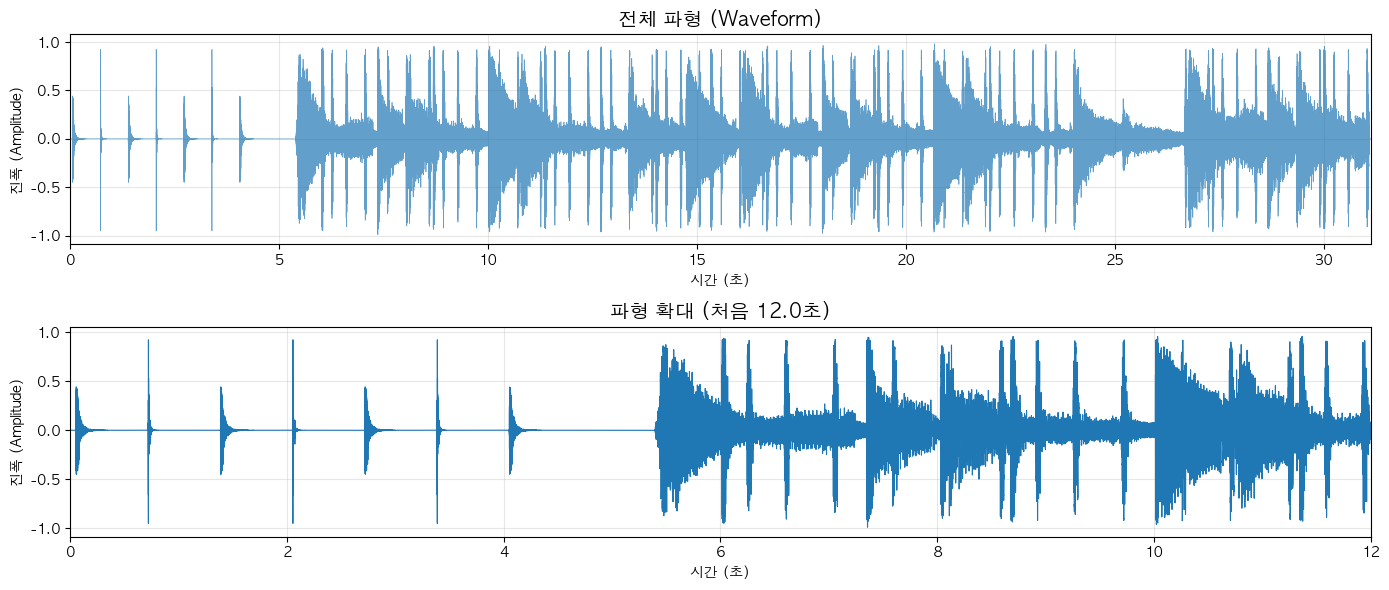

전체 길이: 31.11 초
샘플링 레이트: 22050 Hz


In [28]:
# 파형 시각화
plt.figure(figsize=(14, 6))

# 시간 축 생성
duration = len(y) / sr
time = np.linspace(0, duration, len(y))

# 전체 파형 플롯
plt.subplot(2, 1, 1)
plt.plot(time, y, linewidth=0.5, alpha=0.7)
plt.title('전체 파형 (Waveform)', fontsize=14, fontweight='bold')
plt.xlabel('시간 (초)')
plt.ylabel('진폭 (Amplitude)')
plt.grid(True, alpha=0.3)
plt.xlim(0, duration)

# 처음 10~15초 구간 확대
plt.subplot(2, 1, 2)
zoom_duration = min(12.0, duration)  # 10~15초 또는 전체 길이 중 짧은 것
zoom_samples = int(zoom_duration * sr)
zoom_time = time[:zoom_samples]
zoom_y = y[:zoom_samples]

plt.plot(zoom_time, zoom_y, linewidth=0.8)
plt.title(f'파형 확대 (처음 {zoom_duration:.1f}초)', fontsize=14, fontweight='bold')
plt.xlabel('시간 (초)')
plt.ylabel('진폭 (Amplitude)')
plt.grid(True, alpha=0.3)
plt.xlim(0, zoom_duration)

plt.tight_layout()
plt.show()

print(f"전체 길이: {duration:.2f} 초")
print(f"샘플링 레이트: {sr} Hz")

In [29]:
# Onset + Beat 검출 (Step 1)
# hop_length 작을수록 시간 해상도 좋음 (드럼 타격 잡기 유리)
hop_length = 256

# 전체 믹스: Onset 검출 (민감도 올리기: delta 낮춤, backtrack으로 피크 정교화)
onset_frames = librosa.onset.onset_detect(
    y=y, sr=sr, hop_length=hop_length,
    delta=0.05,        # 임계값 낮춤 → 더 많은 onset 검출 (기본 ~0.07)
    wait=2,            # 최소 2프레임 간격 (중복 피크 억제)
    backtrack=True,    # 피크 위치를 onset strength 곡선 기준으로 보정
)
onset_times = librosa.frames_to_time(onset_frames, sr=sr, hop_length=hop_length)
onset_list = onset_times.tolist()

# Beat 검출 (tempo + 박자 그리드; "매 드럼 타격"이 아니라 4비트당 한 번 수준)
tempo, beat_frames = librosa.beat.beat_track(y=y, sr=sr, hop_length=hop_length)
beat_times = librosa.frames_to_time(beat_frames, sr=sr, hop_length=hop_length)
beat_list = beat_times.tolist()

tempo_val = float(tempo) if hasattr(tempo, 'item') else float(tempo)

# [선택] Demucs로 분리한 drums 스템이 있으면 → 드럼만으로 onset 재계산 (킥/스네어/하이햇 타격 더 잘 잡힘)
track_name = os.path.splitext(os.path.basename(audio_path))[0]
drums_path = os.path.join(project_root, 'audio_engine', 'samples', 'stems', 'htdemucs', track_name, 'drums.wav')
drum_onset_list = []
if os.path.exists(drums_path):
    y_drums, _ = librosa.load(drums_path, sr=sr)
    drum_frames = librosa.onset.onset_detect(
        y=y_drums, sr=sr, hop_length=hop_length,
        delta=0.05, wait=2, backtrack=True,
    )
    drum_onset_list = librosa.frames_to_time(drum_frames, sr=sr, hop_length=hop_length).tolist()
    print(f"드럼 스템 사용: {drums_path}")
else:
    print("드럼 스템 없음 (02_split_stem 먼저 실행 시 drums.wav 기준으로 더 많이 잡힘)")

print(f"검출된 onset 수 (전체): {len(onset_list)}")
print(f"검출된 beat 수 (박자 그리드): {len(beat_list)}")
if drum_onset_list:
    print(f"검출된 드럼 onset 수 (스템 기준): {len(drum_onset_list)}")
print(f"추정 BPM: {tempo_val:.1f}")

드럼 스템 사용: /Users/laxogud/MADCAMP/W4/music-anaylzer/audio_engine/samples/stems/htdemucs/sample_ropes_short/drums.wav
검출된 onset 수 (전체): 114
검출된 beat 수 (박자 그리드): 46
검출된 드럼 onset 수 (스템 기준): 126
추정 BPM: 89.1


/var/folders/6c/v395vbb952ggdz819m67vbg80000gn/T/ipykernel_65099/2218323465.py:20: DeprecationWarning: Conversion of an array with ndim > 0 to a scalar is deprecated, and will error in future. Ensure you extract a single element from your array before performing this operation. (Deprecated NumPy 1.25.)
  tempo_val = float(tempo) if hasattr(tempo, 'item') else float(tempo)


In [30]:
# JSON 스키마로 저장 (onset list, beat list, 드럼 onset 있으면 포함)
import json

out_dir = os.path.join(project_root, 'audio_engine', 'samples')
os.makedirs(out_dir, exist_ok=True)

payload = {
    "source": os.path.basename(audio_path),
    "sr": sr,
    "duration_sec": float(len(y) / sr),
    "tempo_bpm": tempo_val,
    "onset_times_sec": [round(t, 4) for t in onset_list],
    "beat_times_sec": [round(t, 4) for t in beat_list],
}
if drum_onset_list:
    payload["drum_onset_times_sec"] = [round(t, 4) for t in drum_onset_list]

onset_path = os.path.join(out_dir, "onset_beats.json")
with open(onset_path, "w", encoding="utf-8") as f:
    json.dump(payload, f, ensure_ascii=False, indent=2)

print(f"저장: {onset_path}")

저장: /Users/laxogud/MADCAMP/W4/music-anaylzer/audio_engine/samples/onset_beats.json


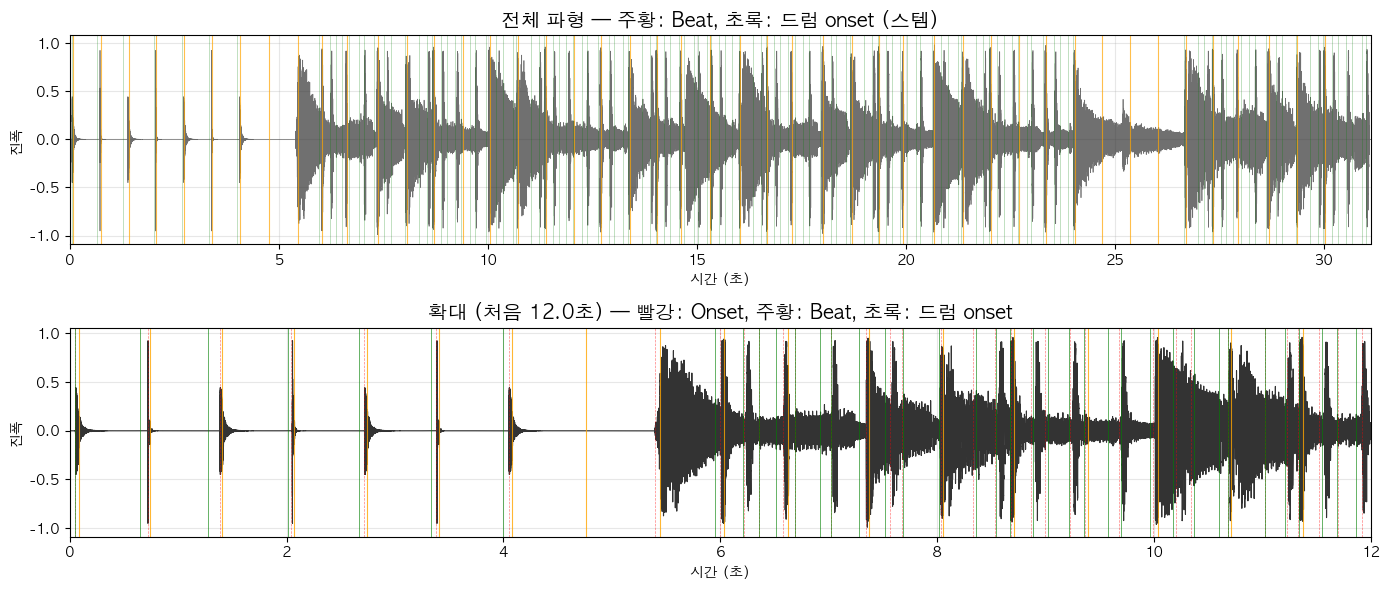

In [31]:
# 파형 위에 onset / beat / 드럼 onset 타격점 시각화
fig, axes = plt.subplots(2, 1, figsize=(14, 6))

# 전체 구간: 파형 + beat + (드럼 onset 있으면 표시)
ax0 = axes[0]
ax0.plot(time, y, linewidth=0.5, alpha=0.7, color='#333')
for t in beat_list:
    ax0.axvline(x=t, color='orange', alpha=0.7, linewidth=0.8)
if drum_onset_list:
    for t in drum_onset_list:
        ax0.axvline(x=t, color='green', alpha=0.35, linewidth=0.5)
    ax0.set_title('전체 파형 — 주황: Beat, 초록: 드럼 onset (스템)', fontsize=14, fontweight='bold')
else:
    ax0.set_title('전체 파형 + Beat', fontsize=14, fontweight='bold')
ax0.set_xlabel('시간 (초)')
ax0.set_ylabel('진폭')
ax0.set_xlim(0, duration)
ax0.grid(True, alpha=0.3)

# 확대 구간: 파형 + onset + beat + 드럼 onset (10~15초)
zoom_duration = min(12.0, duration)
zoom_samples = int(zoom_duration * sr)
zoom_time = time[:zoom_samples]
zoom_y = y[:zoom_samples]
onset_in_zoom = [t for t in onset_list if t < zoom_duration]
beat_in_zoom = [t for t in beat_list if t < zoom_duration]
drum_in_zoom = [t for t in drum_onset_list if t < zoom_duration] if drum_onset_list else []

ax1 = axes[1]
ax1.plot(zoom_time, zoom_y, linewidth=0.8, color='#333')
for t in onset_in_zoom:
    ax1.axvline(x=t, color='red', alpha=0.5, linewidth=0.5, linestyle='--')
for t in beat_in_zoom:
    ax1.axvline(x=t, color='orange', alpha=0.8, linewidth=0.8)
for t in drum_in_zoom:
    ax1.axvline(x=t, color='green', alpha=0.7, linewidth=0.6)
ax1.set_title(f'확대 (처음 {zoom_duration:.1f}초) — 빨강: Onset, 주황: Beat, 초록: 드럼 onset', fontsize=14, fontweight='bold')
ax1.set_xlabel('시간 (초)')
ax1.set_ylabel('진폭')
ax1.set_xlim(0, zoom_duration)
ax1.grid(True, alpha=0.3)

plt.tight_layout()
plt.show()